In [26]:
from pkufinlab import rq_init
rq=rq_init(HF=True)

/root/anaconda3/lib/python3.11/site-packages/rqdatac/client.py:218: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from itertools import product

In [29]:
all_fund=rq.fund.all_instruments(date=None)
#display(all_fund)
fund=all_fund[(all_fund['fund_type']=='Hybrid') | (all_fund['fund_type']=='Stock')]
#display(fund)

In [30]:
all_fund.fund_type.unique()

array(['Hybrid', 'Bond', 'StockIndex', 'Money', 'BondIndex', 'Other',
       'QDII', 'Stock', 'Related'], dtype=object)

In [32]:
fund_list=fund['order_book_id'].tolist()
manager_1=rq.fund.get_manager(fund_list,expect_df=True)
#display(manager_1)
manager_list=manager_1.index.get_level_values('id').unique().tolist()
#display(manager_list)
#print(len(manager_list))

In [33]:
manager_df=rq.fund.get_manager_indicators(manager_list, start_date='2013-01-01', fields=['y1_excess_win','y1_excess_a','y1_stdev_a','y1_sharpe_a','y1_mdd','y1_neg_return_ratio'], asset_type='stock', manage_type='independent',rule='ricequant', market='cn')
#display(manager_df)
manager_mean_df = manager_df.groupby('manager_id').mean()
manager_mean_df=manager_mean_df.dropna()
display(manager_mean_df)

,y1_excess_win,y1_excess_a,y1_stdev_a,y1_sharpe_a,y1_mdd,y1_neg_return_ratio
manager_id,,,,,,
101000001,0.465923,-0.013525,0.156947,-0.407917,0.188858,0.527981
101000008,0.489083,0.039050,0.199886,0.682467,0.191575,0.490310
101000022,0.452931,-0.075213,0.189463,-0.663029,0.219704,0.515103
101000030,0.451354,-0.038709,0.207199,0.098560,0.173122,0.510340
101000082,0.512852,0.088059,0.191459,0.282143,0.156708,0.508120
...,...,...,...,...,...,...
101019732,0.465108,-0.074939,0.181926,1.159135,0.096128,0.497857
101019733,0.511629,-0.035886,0.429008,0.733639,0.334937,0.493874
101019735,0.506371,0.035907,0.274190,1.202241,0.158955,0.506198


In [34]:
performance={'High Performer':[],'Consistent Performer':[],'Under Performer':[]}
win_mean=manager_mean_df['y1_excess_win'].mean()
excess_mean=manager_mean_df['y1_excess_a'].mean()
for index in range(len(manager_mean_df)):
    id=manager_mean_df.index[index]
    #根据超额收益和超额胜率判断该基金经理的绩效情况
    if manager_mean_df.loc[id,'y1_excess_win']>win_mean and manager_mean_df.loc[id,'y1_excess_a']>excess_mean:
        performance['High Performer'].append(id)
    elif manager_mean_df.loc[id,'y1_excess_win']<win_mean and manager_mean_df.loc[id,'y1_excess_a']<excess_mean:
        performance['Under Performer'].append(id)
    else:
        performance['Consistent Performer'].append(id)
#print(performance)

原始数据量: 2379, 剔除异常值后: 2100


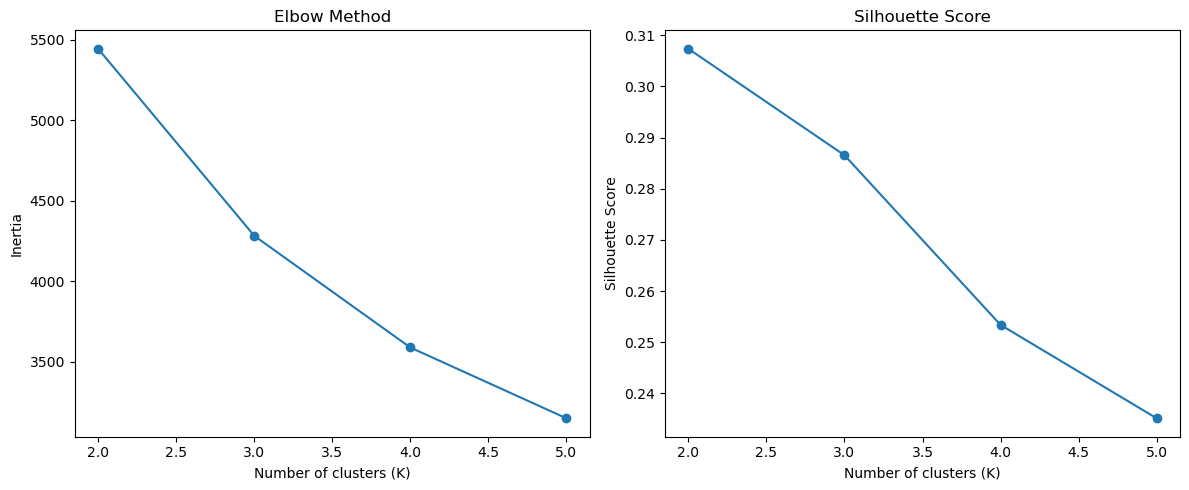

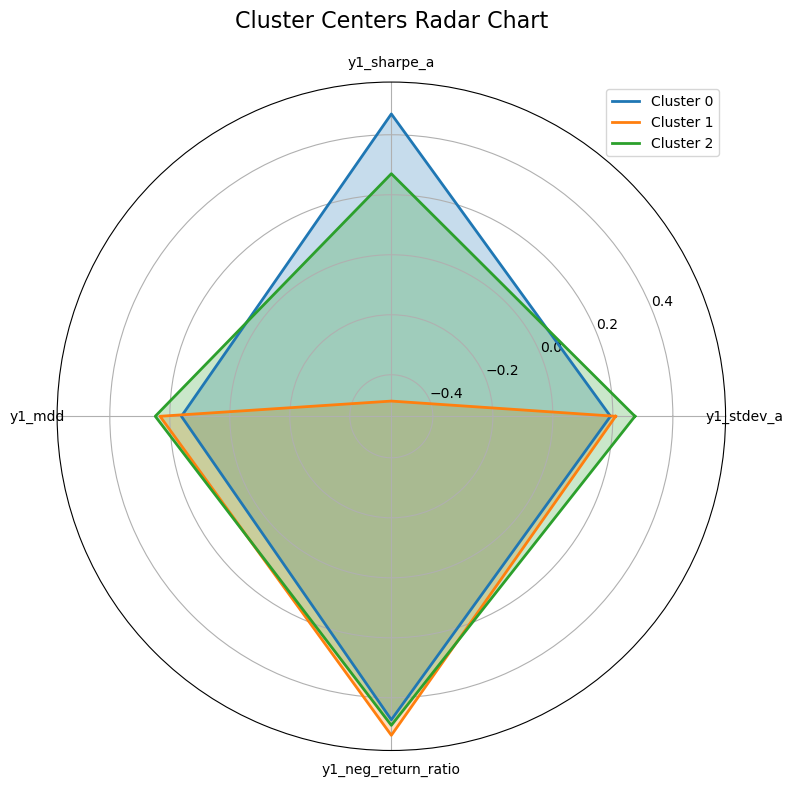

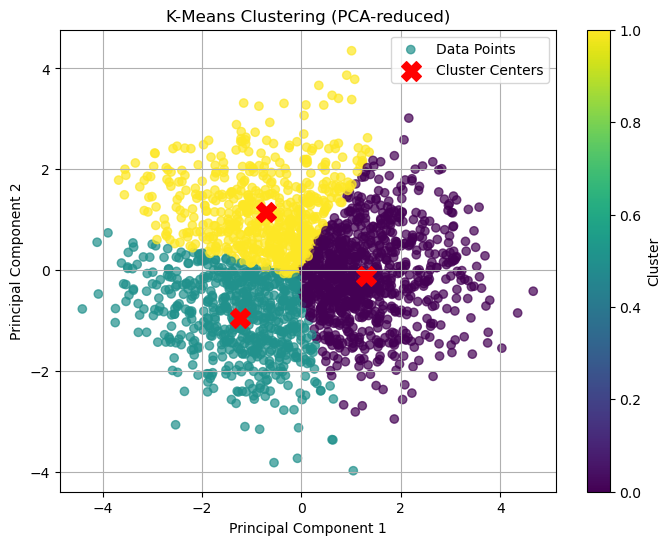


聚类中心（原始尺度）：
   y1_stdev_a  y1_sharpe_a    y1_mdd  y1_neg_return_ratio    Cluster
0    0.192023     0.469316  0.161392             0.473239  Cluster 0
1    0.209348    -0.487810  0.232635             0.524998  Cluster 1
2    0.273648     0.270121  0.248570             0.491851  Cluster 2

基金经理分类结果（剔除异常值后）：
            y1_stdev_a  y1_sharpe_a    y1_mdd  y1_neg_return_ratio Style
manager_id                                                              
101000001     0.156947    -0.407917  0.188858             0.527981   激进型
101000008     0.199886     0.682467  0.191575             0.490310   保守型
101000022     0.189463    -0.663029  0.219704             0.515103   激进型
101000030     0.207199     0.098560  0.173122             0.510340   保守型
101000082     0.191459     0.282143  0.156708             0.508120   保守型
...                ...          ...       ...                  ...   ...
101019684     0.146864     0.149560  0.078497             0.472380   保守型
101019732     0.181926     1.159135

In [39]:
data = manager_mean_df.iloc[:, -4:]

# 1. 异常值检测（IQR方法）
def remove_outliers(df, columns, threshold=1.5):
    clean_df = df.copy()
    for col in columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        clean_df = clean_df[(clean_df[col] >= lower_bound) & (clean_df[col] <= upper_bound)]
    return clean_df

clean_data = remove_outliers(data, ['y1_stdev_a', 'y1_sharpe_a', 'y1_mdd', 'y1_neg_return_ratio'], threshold=1.5)
print(f"原始数据量: {len(data)}, 剔除异常值后: {len(clean_data)}")

# 2. 数据标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_data)

# 3. 确定最佳K值（肘部法则 + 轮廓系数）
K_range = range(2, 6)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# 可视化K值选择
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()

# 4. 执行K-Means聚类（K=3）
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)
clean_data['Cluster'] = clusters

# 5. 分析聚类中心（反标准化）
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=clean_data.columns[:-1])
centers_df['Cluster'] = ['Cluster 0', 'Cluster 1', 'Cluster 2']  # 添加聚类标签

# ---------------------- 新增：质心可视化 ----------------------
# 雷达图展示质心特征
def plot_radar_chart(centers_df):
    labels = centers_df.columns[:-1]
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
    
    for idx, row in centers_df.iterrows():
        values = row.values[:-1].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=f'Cluster {idx}')
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title('Cluster Centers Radar Chart', size=16, pad=20)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_radar_chart(centers_df)

# 6. 可视化（PCA降维）
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7, label='Data Points')
# 标记质心位置
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('K-Means Clustering (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.legend()
plt.grid(True)
plt.show()

# 7. 分类结果解读
clean_data['Style'] = clean_data['Cluster'].map({
    0: '保守型',
    1: '激进型',
    2: '成长型'
})

# ---------------------- 输出结果 ----------------------
print("\n聚类中心（原始尺度）：")
print(centers_df)

print("\n基金经理分类结果（剔除异常值后）：")
print(clean_data[['y1_stdev_a', 'y1_sharpe_a', 'y1_mdd', 'y1_neg_return_ratio', 'Style']])

In [57]:
trading_style={'Conservative':[], 'Balanced':[], 'Aggressive':[]}
for index in range(len(clean_data)):
    id=clean_data.index[index]
    if clean_data.loc[id,'Style']=='激进型':
        trading_style['Aggressive'].append(id)
    if clean_data.loc[id,'Style']=='保守型':
        trading_style['Conservative'].append(id)
    if clean_data.loc[id,'Style']=='成长型':
        trading_style['Balanced'].append(id)
#print(trading_style)

{'Conservative': ['101000008', '101000030', '101000082', '101000091', '101000097', '101000107', '101000131', '101000163', '101000197', '101000204', '101000206', '101000250', '101000266', '101000339', '101000342', '101000344', '101000346', '101000365', '101000376', '101000380', '101000383', '101000394', '101000398', '101000400', '101000401', '101000413', '101000414', '101000415', '101000421', '101000425', '101000430', '101000432', '101000435', '101000437', '101000444', '101000454', '101000458', '101000459', '101000461', '101000477', '101000497', '101000501', '101000509', '101000510', '101000519', '101000524', '101000531', '101000533', '101000535', '101000538', '101000545', '101000548', '101000550', '101000552', '101000554', '101000556', '101000557', '101000561', '101000562', '101000564', '101000573', '101000574', '101000576', '101000579', '101000584', '101000585', '101000586', '101000589', '101000590', '101000595', '101000596', '101000598', '101000603', '101000612', '101000613', '101000

In [56]:
if 'list' in globals() and not callable(list):
    del list
style_categories = list(trading_style.keys())
perf_categories = list(performance.keys())

# 初始化统计DataFrame
stats_df = pd.DataFrame(
    0,
    index=style_categories,
    columns=perf_categories
)

# 统计交叉分类数量
for (style, style_ids), (perf, perf_ids) in product(trading_style.items(), performance.items()):
    common_ids = set(style_ids) & set(perf_ids)
    stats_df.loc[style, perf] = len(common_ids)

# 行列总计
stats_df['Total'] = stats_df.sum(axis=1)
stats_df.loc['Total'] = stats_df.sum(axis=0)

# 百分比DataFrame (按行计算百分比)
percentage_df_r = stats_df.div(stats_df['Total'], axis=0) * 100
percentage_df_r = percentage_df_r.round(1)  # 保留1位小数

# 百分比DataFrame (按列计算百分比)
percentage_df_c = stats_df.div(stats_df.loc['Total'], axis=1) * 100
percentage_df_c = percentage_df_c.round(1)  # 保留1位小数


# 组合显示DataFrame (计数+行百分比)
combined_df = stats_df.copy()
for col in perf_categories:
    combined_df[col] = stats_df[col].astype(str) + " (" + percentage_df_r[col].astype(str) + "%)"

# 组合显示DataFrame (计数+列百分比)
combined_df_c = stats_df.copy()
for col in perf_categories:
    combined_df_c[col] = stats_df[col].astype(str) + " (" + percentage_df_c[col].astype(str) + "%)"
print("=== Original Frequency Distribution ===")
display(stats_df)

#print("\n=== Row-wise Percentage Distribution ===")
#display(percentage_df_r)

#print("\n=== line-wise Percentage Distribution ===")
#display(percentage_df_c)

print("\n=== Frequency Distribution with row-wise Relative Percentages ===")
display(combined_df)

print("\n=== Frequency Distribution with column-wise Relative Percentages ===")
display(combined_df_c)
"""
# 显示详细的ID对应关系
print("\n=== 详细分类对应关系 ===")
for (style, style_ids), (perf, perf_ids) in product(trading_style.items(), performance.items()):
    common_ids = sorted(set(style_ids) & set(perf_ids))
    if common_ids:
        print(f"{style} + {perf}: {common_ids}")
"""

=== Original Frequency Distribution ===


,High Performer,Consistent Performer,Under Performer,Total
Conservative,550,181,169,900
Balanced,289,157,149,595
Aggressive,62,147,396,605
Total,901,485,714,2100



=== Frequency Distribution with row-wise Relative Percentages ===


,High Performer,Consistent Performer,Under Performer,Total
Conservative,550 (61.1%),181 (20.1%),169 (18.8%),900
Balanced,289 (48.6%),157 (26.4%),149 (25.0%),595
Aggressive,62 (10.2%),147 (24.3%),396 (65.5%),605
Total,901 (42.9%),485 (23.1%),714 (34.0%),2100



=== Frequency Distribution with column-wise Relative Percentages ===


,High Performer,Consistent Performer,Under Performer,Total
Conservative,550 (61.0%),181 (37.3%),169 (23.7%),900
Balanced,289 (32.1%),157 (32.4%),149 (20.9%),595
Aggressive,62 (6.9%),147 (30.3%),396 (55.5%),605
Total,901 (100.0%),485 (100.0%),714 (100.0%),2100


'\n# 显示详细的ID对应关系\nprint("\n=== 详细分类对应关系 ===")\nfor (style, style_ids), (perf, perf_ids) in product(trading_style.items(), performance.items()):\n    common_ids = sorted(set(style_ids) & set(perf_ids))\n    if common_ids:\n        print(f"{style} + {perf}: {common_ids}")\n'